In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras import layers, models

#### Loading the dataset

In [242]:
data = os.listdir("../data/Digits" )
data_X = []     
data_y = []  
data_classes = len(data)
for i in range (0, data_classes):
    data_list = os.listdir("../data/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread("../data/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic, (32, 32))
        data_X.append(pic)
        data_y.append(i)
if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


In [243]:
train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


#### Preprocessing

In [244]:
def Prep(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

In [245]:
train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))
#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)
#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

#### One hot encoding

In [246]:
train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

#### Building the model

In [248]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)             

In [1]:
history = model.fit(train_X, train_y, epochs=40, validation_data=(valid_X, valid_y))

NameError: name 'model' is not defined

In [2]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

NameError: name 'model' is not defined

In [251]:
model.save('model.h5')
print('model saved')

model saved


#### Reading sudoku from an image

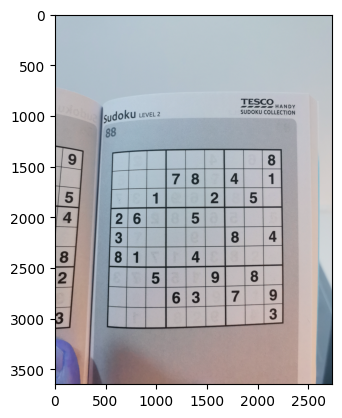

In [252]:
folder="../data/sudoku_imgs"
sudoku_a = cv2.imread(folder+'/'+ '3.jpg')
plt.figure()
plt.imshow(sudoku_a)
plt.show()

#### Preprocessing the image for further analysis

In [253]:
sudoku_a = cv2.resize(sudoku_a, (450,450))
# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3), 6) 
    blur = cv2.bilateralFilter(blur, 9, 75, 75)
    threshold_img = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return threshold_img

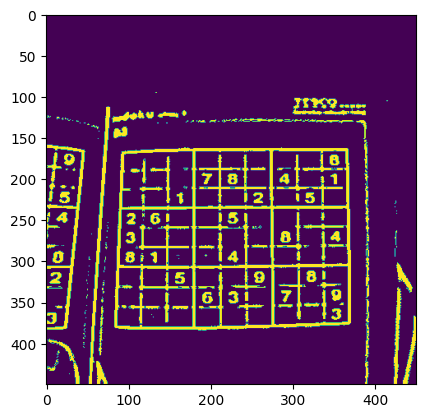

In [254]:
threshold = preprocess(sudoku_a)
plt.figure()
plt.imshow(threshold)
plt.show()

#### Contour detection

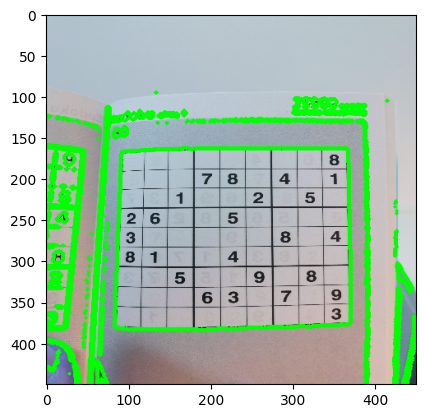

In [255]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour, -1, (0, 255, 0), 3)

plt.figure()
plt.imshow(contour_1)
plt.show()

#### Getting the well aligned grid

In [256]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

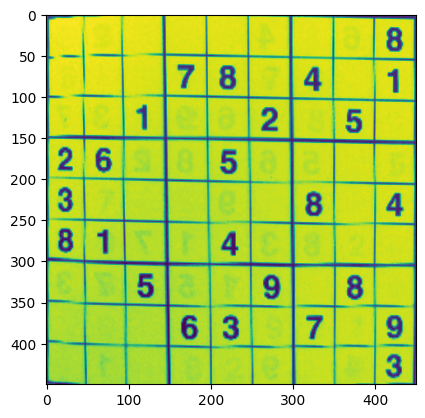

In [257]:
black_img = np.zeros((450, 450, 3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
cv2.drawContours(contour_2,biggest, -1, (0,255,0),10)
pts1 = np.float32(biggest)
pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450, 450))
imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(imagewrap)
plt.show()

#### Check another image

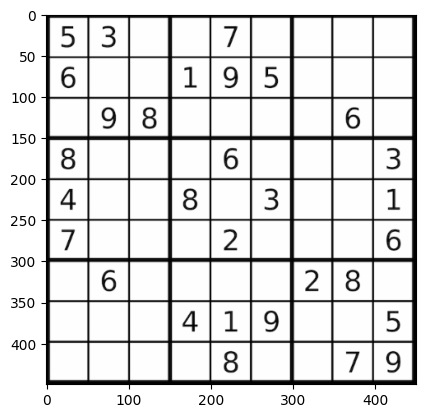

In [258]:
puzzle = cv2.imread("../data/sudoku_imgs/sudo.png")
puzzle = cv2.resize(puzzle, (450,450))
plt.figure()
plt.imshow(puzzle)
plt.show()

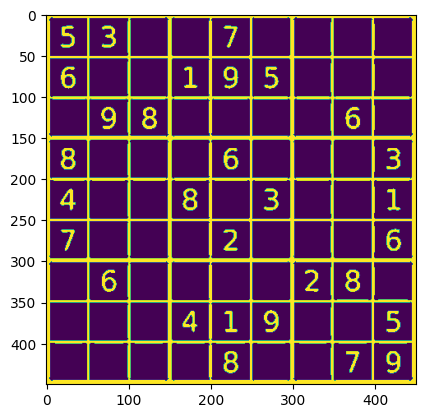

In [259]:
su_threshold = preprocess(puzzle)
plt.figure()
plt.imshow(su_threshold)
plt.show()

In [3]:
su_contour_1 = puzzle.copy()
su_contour_2 = sudoku_a.copy()
su_contour, su_hierarchy = cv2.findContours(su_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour, -1, (0, 255, 0), 3)

plt.figure()
plt.imshow(su_contour_1)
plt.show()

NameError: name 'puzzle' is not defined

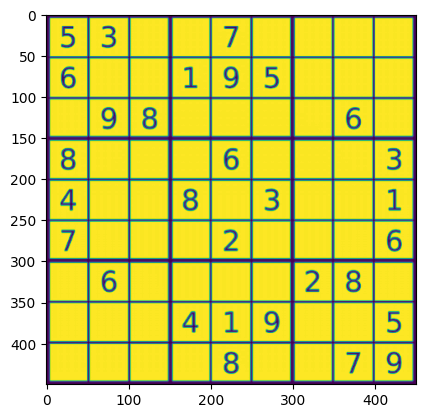

In [261]:
black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
cv2.drawContours(su_contour_2, su_biggest, -1, (0,255,0),10)
su_pts1 = np.float32(su_biggest)
su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

#### Classifying each digits after splitting each cells

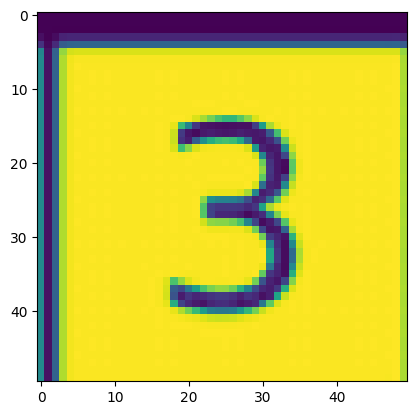

In [268]:
sudoku_cell = splitcells(su_imagewrap)
plt.figure()
plt.imshow(sudoku_cell[1])
plt.show()

In [263]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:
        img = np.array(image)
        img = img[6:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
    return Cells_croped

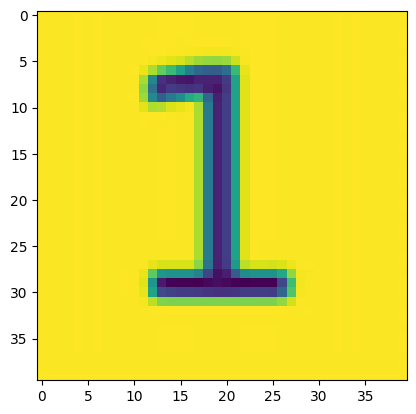

In [264]:
sudoku_cell_croped = CropCell(sudoku_cell)
plt.figure()
plt.imshow(sudoku_cell_croped[67])
plt.show()

In [269]:
new = np.array([cv2.resize(np.array(img), (32, 32)) for img in sudoku_cell_croped])

In [270]:
new.shape

(81, 32, 32)

In [271]:
puzzle_predictions = model.predict(new, verbose=False).argmax(axis=-1)

In [272]:
puzzle_list = np.array(puzzle_predictions)
puzzle_list = puzzle_list.reshape(9,9)
puzzle_list

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]], dtype=int64)

#### Sudoku solver using backtracking

In [273]:
def find_empty_cell(puzzle):
    for i in range(9):
        for j in range(9):
            if puzzle[i][j] == 0:
                return (i, j)
    return None

In [274]:
def valid(puzzle, num, pos):
    # check row
    for i in range(9):
        if puzzle[pos[0]][i] == num and pos[1] != i:
            return False
    # check column
    for i in range(9):
        if puzzle[i][pos[1]] == num and pos[0] != i:
            return False
    # check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if puzzle[i][j] == num and (i, j) != pos:
                return False
    return True

In [275]:
def solve(puzzle):
    find = find_empty_cell(puzzle)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1, 10):
        if valid(puzzle, i, (row, col)):
            puzzle[row][col] = i
            if solve(puzzle):
                return True
            puzzle[row][col] = 0
    return False

In [276]:
def print_puzzle(puzzle):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("-----------------------")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end="")
            if j == 8:
                print(puzzle[i][j])
            else:
                print(str(puzzle[i][j]) + " ", end="")
    return

In [277]:
def solve_sudoku(puzzle):
    print("Puzzle:")
    print_puzzle(puzzle)
    flag = solve(puzzle)
    if flag:
        print("Solution:")
        print_puzzle(puzzle)
    else:
        print("No solution exists for the puzzle, its unsolvable or could be a mistake in classification")
    return


In [278]:
puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9],
  ]
solve_sudoku(puzzle_list)

Puzzle:
5 3 0 |0 7 0 |0 0 0
6 0 0 |1 9 5 |0 0 0
0 9 8 |0 0 0 |0 6 0
-----------------------
8 0 0 |0 6 0 |0 0 3
4 0 0 |8 0 3 |0 0 1
7 0 0 |0 2 0 |0 0 6
-----------------------
0 6 0 |0 0 0 |2 8 0
0 0 0 |4 1 9 |0 0 5
0 0 0 |0 8 0 |0 7 9
Solution:
5 3 4 |6 7 8 |9 1 2
6 7 2 |1 9 5 |3 4 8
1 9 8 |3 4 2 |5 6 7
-----------------------
8 5 9 |7 6 1 |4 2 3
4 2 6 |8 5 3 |7 9 1
7 1 3 |9 2 4 |8 5 6
-----------------------
9 6 1 |5 3 7 |2 8 4
2 8 7 |4 1 9 |6 3 5
3 4 5 |2 8 6 |1 7 9


In [ ]:
# # Create a folder for the dataset
# dataset_folder = "empty_cells"
# os.makedirs(dataset_folder, exist_ok=True)

# # Set image dimensions
# image_size = (128, 128)
# num_images = 1016

# # Generate and save empty Sudoku cell images
# for i in range(num_images):
#     # Create a white image
#     image = Image.new("L", image_size, color=240)

#     # Save the image to the dataset folder
#     image_path = os.path.join(dataset_folder, f"img001-{i}.png")
#     image.save(image_path)

# print(f"{num_images} empty Sudoku cell images generated and saved in the '{dataset_folder}' folder.")


In [ ]:

# # Function to add Gaussian noise to an image
# def add_gaussian_noise(image, mean=0, sigma=25):
#     row, col = image.size
#     gauss = np.random.normal(mean, sigma, (row, col))
#     noisy = np.clip(np.array(image) + gauss, 0, 255)
#     return Image.fromarray(noisy.astype(np.uint8))

# # Create a folder for the dataset
# dataset_folder = "empty_cells_with_noise"
# os.makedirs(dataset_folder, exist_ok=True)

# # Set image dimensions
# image_size = (128, 128)
# num_images = 1016

# # Generate and save empty Sudoku cell images with noise
# for i in range(num_images):
#     # Create a white image
#     image = Image.new("L", image_size, color=240)

#     # Add Gaussian noise to the image
#     noisy_image = add_gaussian_noise(image)

#     # Save the noisy image to the dataset folder
#     image_path = os.path.join(dataset_folder, f"img001-{i}.png")
#     noisy_image.save(image_path)

# print(f"{num_images} empty Sudoku cell images with noise generated and saved in the '{dataset_folder}' folder.")


In [279]:
cells = splitcells(imagewrap)
croped = CropCell(cells)

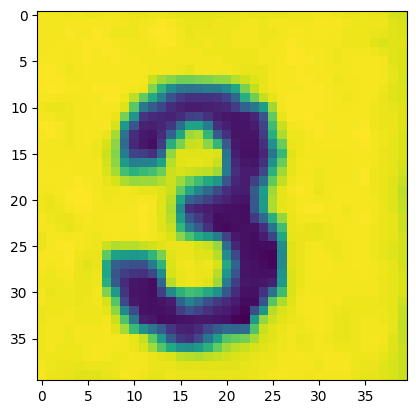

In [280]:
plt.figure()
plt.imshow(croped[80])
plt.show()

In [281]:
other_new = np.array([cv2.resize(np.array(img), (32, 32)) for img in croped])

In [282]:
new_predictions = model.predict(other_new, verbose=False).argmax(axis=-1)

In [283]:
new_puzzle = np.array(new_predictions)
new_puzzle = new_puzzle.reshape(9,9)
new_puzzle

array([[0, 0, 0, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 7, 8, 0, 4, 0, 1],
       [0, 0, 0, 0, 0, 2, 0, 6, 0],
       [2, 9, 0, 0, 9, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 5, 0, 6],
       [8, 9, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 9, 0, 0, 6, 0, 6, 0],
       [0, 0, 0, 6, 5, 0, 7, 0, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=int64)

In [284]:
solve_sudoku(new_puzzle)

Puzzle:
0 0 0 |0 0 0 |0 0 9
0 0 0 |7 8 0 |4 0 1
0 0 0 |0 0 2 |0 6 0
-----------------------
2 9 0 |0 9 0 |0 0 0
3 0 0 |0 0 0 |5 0 6
8 9 0 |0 4 0 |0 0 0
-----------------------
0 0 9 |0 0 6 |0 6 0
0 0 0 |6 5 0 |7 0 6
0 0 0 |0 0 0 |0 0 3
No solution exists for the puzzle, its unsolvable or could be a mistake in classification
